## Hardware-aware training example
- Step 1: Train a digital model on the MNIST dataset using the typical pytorch approach.
- Step 2: Convert the model to analog.
    - Step 2A: Map this model directly to hardware to see the performance without hardware-aware training.
- Step 3: Fine-tune the model using hardware-aware training techniques (e.g. noise injection).
- Step 4: Map fine-tuned model to hardware and evaluate.

In [18]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from aihwkit.simulator.rpu_base import cuda

plt.style.use('ggplot')

In [28]:
# Check device
USE_CUDA = 0
if cuda.is_compiled():
    USE_CUDA = 1
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f'Using device: {DEVICE}')

# Path where the datasets will be stored.
PATH_DATASET = os.path.join('/scratch/msc24h18/msc_project/data', 'DATASET')

# Network definition.
INPUT_SIZE = 784
HIDDEN_SIZES = [256, 128]
OUTPUT_SIZE = 10

# Training parameters.
EPOCHS = 20
BATCH_SIZE = 64

Using device: cuda


### Define hardware properties
Here we create the RPU Config that defines the properties and non-idealities of the hardware.

In [29]:
from aihwkit.simulator.presets.utils import IOParameters
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.configs.utils import (
    WeightModifierType,
    BoundManagementType,
    WeightClipType,
    NoiseManagementType,
    WeightRemapType,
)

def gen_rpu_config():
    rpu_config = InferenceRPUConfig()
    rpu_config.modifier.std_dev = 0.06
    rpu_config.modifier.type = WeightModifierType.ADD_NORMAL

    rpu_config.mapping.digital_bias = True
    rpu_config.mapping.weight_scaling_omega = 1.0
    rpu_config.mapping.weight_scaling_columnwise = False
    rpu_config.mapping.out_scaling_columnwise = False
    rpu_config.remap.type = WeightRemapType.LAYERWISE_SYMMETRIC

    rpu_config.clip.type = WeightClipType.LAYER_GAUSSIAN
    rpu_config.clip.sigma = 2.0

    rpu_config.forward = IOParameters()
    rpu_config.forward.is_perfect = False
    rpu_config.forward.out_noise = 0.0
    rpu_config.forward.inp_bound = 1.0
    rpu_config.forward.inp_res = 1 / (2**8 - 2)
    rpu_config.forward.out_bound = 12
    rpu_config.forward.out_res = 1 / (2**8 - 2)
    rpu_config.forward.bound_management = BoundManagementType.NONE
    rpu_config.forward.noise_management = NoiseManagementType.NONE

    rpu_config.pre_post.input_range.enable = True
    rpu_config.pre_post.input_range.decay = 0.01
    rpu_config.pre_post.input_range.init_from_data = 50
    rpu_config.pre_post.input_range.init_std_alpha = 3.0
    rpu_config.pre_post.input_range.input_min_percentage = 0.995
    rpu_config.pre_post.input_range.manage_output_clipping = False

    rpu_config.noise_model = PCMLikeNoiseModel(g_max=25.0)
    rpu_config.drift_compensation = GlobalDriftCompensation()
    return rpu_config

### Step 1: Training digital model
First we define the usual train and test routines and data loaders:

In [30]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch import nn, Generator

os.makedirs(PATH_DATASET, exist_ok=True)

def get_data_loaders(batch_size=BATCH_SIZE):
    """Get the data loaders for train from torchvision datasets."""

    trainval_set = MNIST(PATH_DATASET, download=True, train=True, transform=ToTensor())
    test_set = MNIST(PATH_DATASET, download=True, train=False, transform=ToTensor())

    seed = Generator().manual_seed(123)
    train_set, valid_set = random_split(trainval_set, [0.8, 0.2], generator=seed)

    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=23)
    valid_data = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=23)
    test_data = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=23)

    return train_data, valid_data, test_data

# train and test routines
def train(model, train_set, valid_set, optimizer, scheduler):
    """Train the network.

    Args:
        model (nn.Module): model to be trained.
        train_set (DataLoader): dataset of elements to use as input for training.
        valid_set (DataLoader): dataset of elements to use as input for validation.

    Returns:
        metrics (np.ndarray): array with the following values in the columns: epoch, train_loss, valid_loss, valid_accuracy.
    """
    metrics = np.zeros((EPOCHS, 4))

    classifier = nn.NLLLoss()

    for epoch_number in range(EPOCHS):
        print(f"Epoch {epoch_number}:")
        total_loss = 0
        for i, (images, labels) in enumerate(train_set):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # Flatten MNIST images into a 784 vector.
            images = images.view(images.shape[0], -1)

            optimizer.zero_grad()
            # Add training Tensor to the model (input).
            output = model(images)
            loss = classifier(output, labels)

            # Run training (backward propagation).
            loss.backward()

            # Optimize weights.
            optimizer.step()

            total_loss += loss.item()

        print("\t- Training loss: {:.16f}".format(total_loss / len(train_set)))

        # Evaluate the model.
        predicted_ok = 0
        total_images = 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in valid_set:
                # Predict image.
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                images = images.view(images.shape[0], -1)
                pred = model(images)
                loss = classifier(pred, labels)
                val_loss += loss.item()

                _, predicted = torch.max(pred.data, 1)
                total_images += labels.size(0)
                predicted_ok += (predicted == labels).sum().item()

            print(f"\t- Validation loss: {val_loss / len(valid_set):.16f}")
            print(f"\t- Validation accuracy: {predicted_ok / total_images:.4f}")

        # Decay learning rate if needed.
        scheduler.step()

        # Update metrics.
        metrics[epoch_number, 0] = epoch_number
        metrics[epoch_number, 1] = total_loss / len(train_set) # train_loss
        metrics[epoch_number, 2] = val_loss / len(valid_set) # valid_loss
        metrics[epoch_number, 3] = predicted_ok / total_images # valid_accuracy

    return metrics


def test(model, test_set):
    """Test trained network

    Args:
        model (nn.Model): Trained model to be evaluated
        test_set (DataLoader): Test set to perform the evaluation
    """
    # Setup counter of images predicted to 0.
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in test_set:
        # Predict image.
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        images = images.view(images.shape[0], -1)
        pred = model(images)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    print("\nNumber Of Images Tested = {}".format(total_images))
    print("Model Accuracy = {}".format(predicted_ok / total_images))

def plot_metrics(metrics):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(metrics[:, 0], metrics[:, 1], label='Train Loss')
    ax[0].plot(metrics[:, 0], metrics[:, 2], label='Validation Loss')
    ax[0].set(xlabel='Epoch', ylabel='Loss')
    ax[0].legend()

    ax[1].plot(metrics[:, 0], 100-100*metrics[:, 3])
    ax[1].set(xlabel='Epoch', ylabel='Validation Error')
    plt.show()

Now we define the model and train it.

Epoch 0:


	- Training loss: 0.2706986278891563
	- Validation loss: 0.1629036814866072
	- Validation accuracy: 0.9505
Epoch 1:
	- Training loss: 0.1113485212077697
	- Validation loss: 0.1360934979549827
	- Validation accuracy: 0.9597
Epoch 2:
	- Training loss: 0.0839381709384421
	- Validation loss: 0.1332969309841382
	- Validation accuracy: 0.9595
Epoch 3:
	- Training loss: 0.0653095571487211
	- Validation loss: 0.1165549417764464
	- Validation accuracy: 0.9650
Epoch 4:
	- Training loss: 0.0616260363046701
	- Validation loss: 0.1148116495596503
	- Validation accuracy: 0.9678
Epoch 5:
	- Training loss: 0.0575263622140046
	- Validation loss: 0.1075341418952721
	- Validation accuracy: 0.9701
Epoch 6:
	- Training loss: 0.0539906926420517
	- Validation loss: 0.1110837634546345
	- Validation accuracy: 0.9695
Epoch 7:
	- Training loss: 0.0480145533202449
	- Validation loss: 0.1142977654699860
	- Validation accuracy: 0.9687
Epoch 8:
	- Training loss: 0.0479164905243864
	- Validation loss: 0.1074310931391

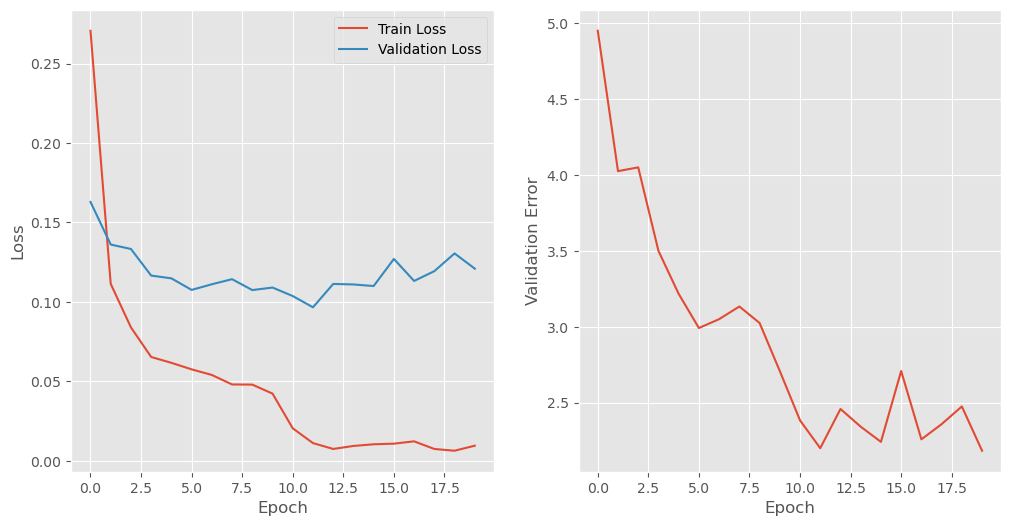

In [32]:
model = nn.Sequential(
        nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], True),
        nn.Sigmoid(),
        nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], True),
        nn.Sigmoid(),
        nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, True),
        nn.LogSoftmax(dim=1)
    )

if USE_CUDA:
        model.cuda()

# train model
train_set, valid_set, test_set = get_data_loaders()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
metrics_digital = train(model, train_set, valid_set, optimizer, scheduler)
test(model, test_set)
plot_metrics(metrics_digital)

## Step 2: Convert the model to analog

In [35]:
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.optim import AnalogSGD

analog_model_no_ft = convert_to_analog(model, gen_rpu_config())
analog_model_no_ft.eval()
analog_model_no_ft.program_analog_weights()
test(analog_model_no_ft, test_set)


Number Of Images Tested = 10000
Model Accuracy = 0.9786


### Step 3: Fine-tune

Epoch 0:
	- Training loss: 0.1042564254027869
	- Validation loss: 0.1955282444065001
	- Validation accuracy: 0.9563
Epoch 1:
	- Training loss: 0.0596066487660864
	- Validation loss: 0.1556835225281712
	- Validation accuracy: 0.9640
Epoch 2:
	- Training loss: 0.0480178944501386
	- Validation loss: 0.1615927341304957
	- Validation accuracy: 0.9643
Epoch 3:
	- Training loss: 0.0423969536233829
	- Validation loss: 0.1550092441234193
	- Validation accuracy: 0.9653
Epoch 4:
	- Training loss: 0.0391833707780655
	- Validation loss: 0.1568897854545441
	- Validation accuracy: 0.9654
Epoch 5:
	- Training loss: 0.0364597563320228
	- Validation loss: 0.1572780158848160
	- Validation accuracy: 0.9652
Epoch 6:
	- Training loss: 0.0353591131763145
	- Validation loss: 0.1536808353650602
	- Validation accuracy: 0.9670
Epoch 7:
	- Training loss: 0.0339590519563935
	- Validation loss: 0.1522355178357758
	- Validation accuracy: 0.9674
Epoch 8:
	- Training loss: 0.0329702622223995
	- Validation loss: 0.1506

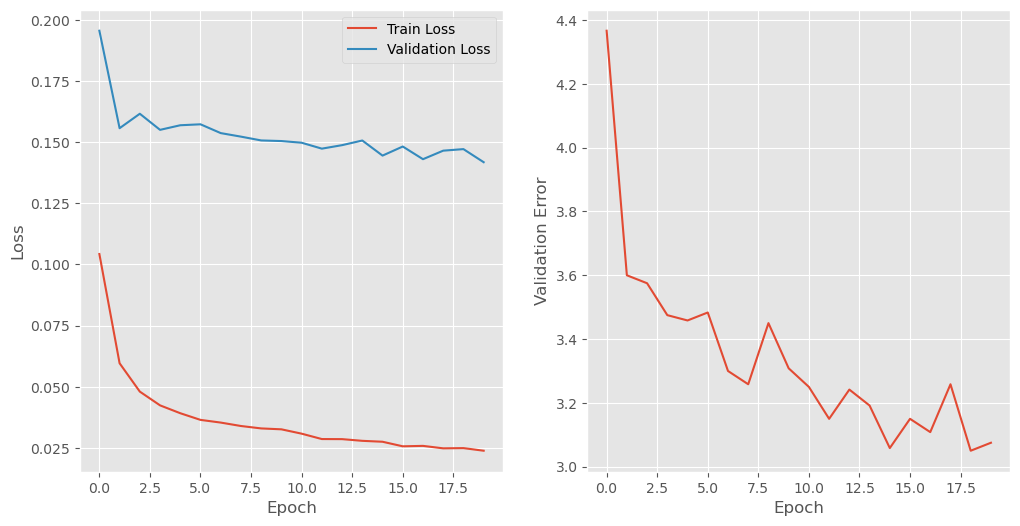

In [37]:
analog_model_ft = convert_to_analog(model, gen_rpu_config())

analog_optimizer = AnalogSGD(analog_model_ft.parameters(), lr=0.01)
metrics_analog_ft = train(analog_model_ft, train_set, valid_set, analog_optimizer, scheduler)
test(analog_model_ft, test_set)
plot_metrics(metrics_analog_ft)

### Step 4: Evaluate in hardware

In [38]:
analog_model_ft.eval()
analog_model_ft.program_analog_weights()
test(analog_model_ft, test_set)


Number Of Images Tested = 10000
Model Accuracy = 0.9718
